# Generate dataset for image segmentation from a live video camera

We now use a simple GUI to generate new dataset for image segmentation. 

Here are the steps:


* Get an image from a camera (could later be a video or images). 
* Click on the video to extract one image, and then click again to label the oject on the image.
* Save image, coordinate and mask to the dataset.
* Split images and mask as a train and validation dataset.

You want at least 150 imgaes to get ok tracking. We can further improve the model later on.

In [2]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import ipywidgets as widgets
from ipyevents import Event 
import threading
from IPython.display import display
from camera import USBCamera, bgr8_to_jpeg
from multiClassUNetDataset import MultiClassUNetDataset
from trackingProject import TrackingProject
from unetGUI import LabelFromCameraGUI

## Create a project

All the configuration is stored in the project object. You can modify the configuration by modifying the `config.yalm` file and loading it. 

If it is the creation of the project, run the cell below.

In [3]:
#project = TrackingProject(name="faceTrack",root_folder = "/home/kevin/Documents/trackingProjects/",object_list=["nose","chin","rEye","lEye"],target_radius=10)
#project.create_project_directories()
#project.save_configuration()

If you already have a project, run the cell below.

In [4]:
project = TrackingProject(name="faceTrack",root_folder = "/home/kevin/Documents/trackingProjects/")

Project directory: /home/kevin/Documents/trackingProjects/faceTrack
Loading /home/kevin/Documents/trackingProjects/faceTrack/config.yalm
{'augmentation_HorizontalFlipProb': 0.0, 'augmentation_RandomBrightnessContrastProb': 0.2, 'augmentation_RandomSizedCropProb': 1.0, 'augmentation_RotateProb': 0.3, 'image_size': [480, 640], 'labeling_ImageEnlargeFactor': 2.0, 'name': 'faceTrack', 'object_colors': [(0.0, 0.0, 255.0), (255.0, 0.0, 0.0), (255.0, 255.0, 0.0), (128.0, 0.0, 128.0)], 'objects': ['nose', 'chin', 'rEye', 'lEye'], 'target_radius': 10}


In [5]:
dataset = MultiClassUNetDataset(image_dir=project.image_dir, mask_dir=project.mask_dir, coordinates_dir=project.coordinates_dir)

In [6]:
len(dataset)

370

## Get images from a camera

We can use OpenCV to get images from a camera.

In [6]:
!ls -ltrh /dev/video*

crw-rw----+ 1 root video 81, 1 Nov 24 07:39 /dev/video1
crw-rw----+ 1 root video 81, 0 Nov 24 07:39 /dev/video0


## Camera class running its own thread

We want the imgWidget to be updated from a different thread. For this we need to build a camera thread.
This should allow us to record click events on our image.

This is similar to the NVIDIA jetcam/camera.py class.


In [7]:
camera = USBCamera(width=project.image_size[1], height=project.image_size[0])

In [8]:
image = camera.read()
print(image.shape)


(480, 640, 3)


In [9]:
imgWidget = widgets.Image(format='jpeg')
imgWidget.value = bgr8_to_jpeg(image)
display(imgWidget)

Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x02\x01\x0…

# Extract and label images from video feed

We need a function to save the current image and mask.

I create a folder called `noseDataset` with a subfolder `train` and `train_mask`

In [10]:
project.image_dir,project.mask_dir

('/home/kevin/Documents/trackingProjects/faceTrack/dataset/images',
 '/home/kevin/Documents/trackingProjects/faceTrack/dataset/mask')

In [11]:
dataset = MultiClassUNetDataset(image_dir=project.image_dir, mask_dir=project.mask_dir, coordinates_dir=project.coordinates_dir)

In [12]:
gui = LabelFromCameraGUI(camera,project,dataset)

In [22]:
gui.stop_video()

In [23]:
print(len(dataset))
      

326


In [24]:
image, mask, coordinates = dataset[0]

In [25]:
image.shape, mask.shape, coordinates.shape

(torch.Size([3, 480, 640]), torch.Size([4, 480, 640]), (4, 2))

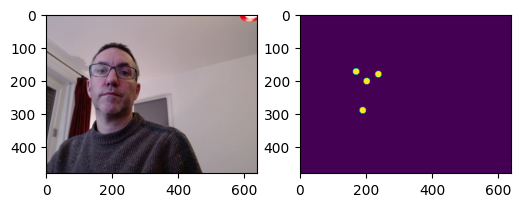

In [26]:
fig , ax = plt.subplots(1,2, figsize=(6,3))
ax[0].imshow(image.permute(1,2,0))
ax[1].imshow(mask.permute(1,2,0).sum(axis=2))



# Create training and validation sets

The images and masks were saved in an `images` and `masks` directories. We need to create `train_images`, `train_masks`, `val_images` and `val_masks` directories.

We will use the validation folders to estimate the accuracy of our model on data that it has not seen during training.

In [27]:
project.image_dir,project.mask_dir

('/home/kevin/Documents/trackingProjects/faceTrack/dataset/images',
 '/home/kevin/Documents/trackingProjects/faceTrack/dataset/mask')

In [28]:
dataset.create_training_validation_dataset(train_images_dir = "/home/kevin/Documents/trackingProjects/faceTrack/dataset/train_images",
                                           train_masks_dir = "/home/kevin/Documents/trackingProjects/faceTrack/dataset/train_masks",
                                           train_coordinates_dir = "/home/kevin/Documents/trackingProjects/faceTrack/dataset/train_coordinates",
                                               
                                           val_images_dir = "/home/kevin/Documents/trackingProjects/faceTrack/dataset/val_images",
                                           val_masks_dir = "/home/kevin/Documents/trackingProjects/faceTrack/dataset/val_masks",
                                           val_coordinates_dir = "/home/kevin/Documents/trackingProjects/faceTrack/dataset/val_coordinates",
                                           test_size=0.15)

Length of training set: 277
Length of validation set: 49
Copying files to training and validation directories


In [29]:
train_images_dir = "/home/kevin/Documents/trackingProjects/faceTrack/dataset/train_images"
train_masks_dir = "/home/kevin/Documents/trackingProjects/faceTrack/dataset/train_masks"
train_coordinates_dir = "/home/kevin/Documents/trackingProjects/faceTrack/dataset/train_coordinates"
trainDataset = MultiClassUNetDataset(image_dir=train_images_dir, mask_dir=train_masks_dir,coordinates_dir=train_coordinates_dir)
len(trainDataset)

277

In [30]:
val_images_dir = "/home/kevin/Documents/trackingProjects/faceTrack/dataset/val_images"
val_masks_dir = "/home/kevin/Documents/trackingProjects/faceTrack/dataset/val_masks"
val_coordinates_dir = "/home/kevin/Documents/trackingProjects/faceTrack/dataset/val_coordinates"
valDataset = MultiClassUNetDataset(image_dir=val_images_dir, mask_dir=val_masks_dir,coordinates_dir=val_coordinates_dir)
len(valDataset)

49

We are now ready to train a network with this data.